# Measuring Variation in the Empirical Storm Season Over Time

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Measuring-Variation-in-the-Empirical-Storm-Season-Over-Time" data-toc-modified-id="Measuring-Variation-in-the-Empirical-Storm-Season-Over-Time-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Measuring Variation in the Empirical Storm Season Over Time</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Related-Research" data-toc-modified-id="Related-Research-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Related Research</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Has-the-variation-in-the-empirical-storm-season-changed-over-time?" data-toc-modified-id="Has-the-variation-in-the-empirical-storm-season-changed-over-time?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Has the variation in the empirical storm season changed over time?</a></span><ul class="toc-item"><li><span><a href="#State-Space-Model" data-toc-modified-id="State-Space-Model-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>State Space Model</a></span><ul class="toc-item"><li><span><a href="#Model-Priors" data-toc-modified-id="Model-Priors-5.1.1.1"><span class="toc-item-num">5.1.1.1&nbsp;&nbsp;</span>Model Priors</a></span></li></ul></li><li><span><a href="#Atlantic-Ocean" data-toc-modified-id="Atlantic-Ocean-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Atlantic Ocean</a></span></li><li><span><a href="#Pacific-Ocean" data-toc-modified-id="Pacific-Ocean-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Pacific Ocean</a></span></li></ul></li><li><span><a href="#Annual-percentage-of-storms-outside-official-storm-season-changing?" data-toc-modified-id="Annual-percentage-of-storms-outside-official-storm-season-changing?-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Annual percentage of storms outside official storm season changing?</a></span><ul class="toc-item"><li><span><a href="#Atlantic-Ocean" data-toc-modified-id="Atlantic-Ocean-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Atlantic Ocean</a></span></li><li><span><a href="#Pacific-Ocean" data-toc-modified-id="Pacific-Ocean-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Pacific Ocean</a></span></li></ul></li><li><span><a href="#Is-the-Distribution-of-the-Empirical-Storm-Season-Stationary?" data-toc-modified-id="Is-the-Distribution-of-the-Empirical-Storm-Season-Stationary?-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Is the Distribution of the Empirical Storm Season Stationary?</a></span><ul class="toc-item"><li><span><a href="#Atlantic-Ocean" data-toc-modified-id="Atlantic-Ocean-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Atlantic Ocean</a></span></li><li><span><a href="#Pacific-Ocean" data-toc-modified-id="Pacific-Ocean-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Pacific Ocean</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Acknowledgments" data-toc-modified-id="Acknowledgments-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Acknowledgments</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Licenses" data-toc-modified-id="Licenses-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Licenses</a></span></li></ul></div>

# Introduction

XXX

This blog post attempts an analysis of the annual variability of dates on which storms form.  Throughout, the word storm will refer generally to named hurricanes or tropical cyclones in either the Atlantic or the Pacific oceans.  The inspiration of this analysis came from a [CSU, Chico](http://www.csuchico.edu/) campus seminar.

During the Fall semester of 2017, CSU, Chico's [Dr. Ann Bykerk-Kauffman](http://www.csuchico.edu/%7eabykerk-kauffman/) gave one of three talks at the [Department of Geological and Environmental Sciences](http://www.csuchico.edu/geos/index.shtml) seminar titled [2017 Hurricane Talk](http://www.csuchico.edu/geos/stories/17.09.14_HurricaneTalk.shtml).  Part of Dr. Bykerk-Kauffman's presentation included data from the National Oceanic and Atmospheric Administration's National Hurricane Center's (NHC) Data Archive: https://www.nhc.noaa.gov/data/#hurdat [Landsea:2013].  After her talk, Dr. David M. Hassenzahl, Dean of the [College of Natural Sciences](https://www.csuchico.edu/nsci/index.shtml), asked a great question, which I'll try to paraphrase:  Is the variation of the empirical storm season changing over time?

One possible way to interpret the phrase *variation of the empirical storm season* goes like this.  The [official storm season](https://en.wikipedia.org/wiki/Atlantic_hurricane_season) is June 01 to November 30.  The official storms season proves useful as a contrast to an empirical storm season.  The word empirical refers to the actual dates for which the named storms in any given year form.  Just because we define a storm season, does not mean all the storms form within the official storm season.  Some years contain some storms outside the official storm season, and some years contain all storms witihin the official storm season -- as we'll see later, no year in our data set has all storms outside of the official storm season.  Since there is not a direct correspondence between the official storm season and the empirical storm season, it's useful to separate these two phrases.  Last, the word variation describes the average distance (measured in days) from the middle of the empirical storm season.

There are of course other ways to measure the variation of the empirical storm season.  This blog post attempts to quantify the annual variation of the empirical storm season in three different ways.  The first attempt follows the logic in the last paragraph.  The second attempt defines a percentage of storms that form outside of the official storm season, relative to the total number of storms in each year.  The last attempt hypothesizes a probability distribution that produces storms throughout the year, and then asks if this distribution of storms changes over time.

The rest of this post proceeds as follows.  Section 2 discusses some related research and briefly compares the analysis here to previous efforts.  Section 3 walks through the data preparation necessary for our analyses.  Section 4 contains the bulk of the analysis, for which multiple measurements of variation of the storm season are considered as a time series.  In a seemingly uncommon move, we've lumped together data from both the Atlantic and the Pacific oceans for the years 1851 to 2016.  There is no qualitative, and only minor quantitative, differences found by breaking up the data by time, space, or both, and Section 9 provides the evidence of this.  The post is concluded in Section 6, and Sections 7 and 8 offer my appreciation to those who directly and indirectly made this analysis possible.

# Related Research

Much research effort is spent on storms of both the Atlantic and Pacfic oceans.  For instance, just a quick glance of [NOAA's media releases](http://www.noaa.gov/media-releases) shows that much of their latest research revolves around the storm season.  With a little more attention to their articles, it's clear that much of this work focuses on storm intensity and/or number of storms.  Less research is devoted to the variation in the storm season.

In 2008, Kossin tried to answer "Is the North Atlantic hurricane season getting longer?" [Kossin:2008].  Based on the sign of his point estimates, Kossin concluded that the hurricane season is indeed getting longer.  This was the conclusion despite high uncertainty in the point estimates.  For the analysis, Kossin used quantile regression on the dates for which storms formed within each year.  We note that quantile regression inherently treats the observations as independent acorss time.

Despite no statistically significant finding, due to high uncertainty, at least two websites picked up on Kossin's article: [Live Science](https://www.livescience.com/2686-hurricane-season-longer.html) and [Wunderground](https://www.wunderground.com/blog/JeffMasters/is-the-atlantic-hurricane-season-getting-longer.html).  Within each story, the uncertainty is glossed over.  This stands in stark contrast to Karloski's summary of Kossin's work [Karloski:2016].  Karloski replicated Kossin's work and provided stronger wording about the uncertain estimates of an increase in variation.  

In 2017, evidence of correlations in the storm seasons across time surfaced in the article "Variation of the Tropical Cyclone Season Start in the Western North Pacific" [Kim:2017].  Specifically, the authors found that a strong El Niño year will delay the start of the storm season in the following year.  This analysis, too, treated the annual measurements of the storm season as independent across time.  Using linear regression applied to a statistic similar to the interquartile range (using percentiles 95% and 5%, instead of 75% and 25%), Kim found a statistically insignificant shrink in the storm season. 

Like these previous studies, the following analysis attempts to measure the variation in the storm season by using the dates within the year that named storms first formed.  Unlike these previous studies, this study fits a model more appropriate to time series data.  We use a semilocal linear trend model to account for potential autocorrelation in the storm season.  Further, we expand on the idea of variation by introducing novel measures of variation of the storm season.

# Data Preparation

We begin by setting up the working environment: loading [Python](https://www.python.org) and various packages common to Python's data science community, including [Stan](http://mc-stan.org) the probabilistic programming language which we'll use to fit a Bayesian structural time series model.

The HURDAT2 [Landsea:2013] data used here was processed from the NHC data archive to enable this analysis.  The source code and data are available on [GitHub](https://github.com/roualdes/stormevents).

In [15]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import bplot as bp
import datetime
import pystan
import stan_utility
import requests
%matplotlib inline
rc('text', usetex=True)

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/stormevents/master/data.csv')

To properly work with dates in Python, we convert dates, from the format YYYMMDD, into formal datetime objects.  We assign numbers to dates by counting days since 0001-01-01 UTC plus 1; see [matplotlib dates](https://matplotlib.org/api/dates_api.html) for technical details.   

In [27]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.drop_duplicates('name', inplace=True) # don't double count storms
df['year'] = df.date.dt.year 
df = df.loc[df['year'] >= 1950]
df['month'] = df.date.dt.month
df['cnum_dates'] = mdates.date2num([datetime.datetime(2018, d.month, d.day)                     
                         for _, d in df['date'].dropna().iteritems()]) 
df['num_dates'] = mdates.date2num([datetime.datetime(d.year, d.month, d.day)                     
                         for _, d in df['date'].iteritems()])
Adf = df.loc[df['name'].str.contains('^AL')].copy() # Atlantic, for now
Adf.head()

,date,time,record_identifier,intensity_rating,name,year,month,cnum_dates,num_dates
21879,1950-08-12,0.0,NaN,TS,AL011950,1950,8,736918.0,712081.0
21930,1950-08-18,1200.0,NaN,TD,AL021950,1950,8,736924.0,712087.0
21990,1950-08-21,1200.0,NaN,TS,AL031950,1950,8,736927.0,712090.0
22051,1950-08-30,1800.0,NaN,HU,AL041950,1950,8,736936.0,712099.0
22125,1950-09-01,600.0,NaN,TS,AL051950,1950,9,736938.0,712101.0


With dates properly set up, we can easily visualize the total number of storms each year.  The plot below shows that the number of storms occuring each year is increasing in time.

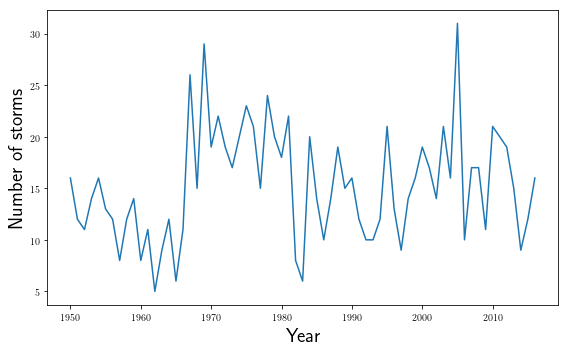

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(Adf['year'].unique(), 
         Adf['date'].dt.year.value_counts().sort_index())
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of storms', fontsize=20)
plt.tight_layout()

Or we can sum, within each month, the number storms that hit either the Pacific or Atlantic oceans.  September appears to be the most common month for a storm.

In [19]:
Adf['date'].dt.month.value_counts().sort_index()

1       3
2       1
4       5
5      25
6      73
7     113
8     251
9     332
10    163
11     47
12     11
Name: date, dtype: int64

Similar information is displayed with a histogram.  The histogram is nice because we can see how well the official storm season captures the highest density of storms.  Like above, the plot below is aggregated over all the years for which we have data.
<a id='average_density'></a>

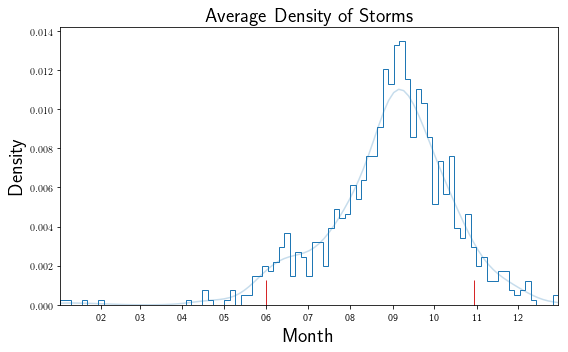

In [20]:
storm_season = mdates.date2num([datetime.datetime(2018, 6, 1), 
                                datetime.datetime(2018, 10, 30)])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()      
bp.histogram(Adf['cnum_dates'], bins=365//4)
bp.density(Adf['cnum_dates'], alpha=0.25) 
bp.rug(storm_season, markersize=50, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Average Density of Storms', fontsize=20)
ax.set_xlim([df['cnum_dates'].min(), df['cnum_dates'].max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))                          
plt.tight_layout()

Averaged across all years, there is less than 10% of storms that fall outside of the official storm season.  Below is the calculation of the percentage of storms within the official storm season. Of course, this calculation ignores the year to year variation in this percentage.  

In [25]:
np.sum((Adf['cnum_dates'] > storm_season[0]) & (Adf['cnum_dates'] < storm_season[1])) / Adf.shape[0] * 100

90.52734375

# Analysis

## Has the variation in the empirical storm season changed over time?

In an effort to answer Dean Hassenzahl's question, we attempt to measure the variation of the empirical storm season year over year.  To measure such variation, we will use the [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD) statistic.  The MAD statistic is an estimator of the population standard deviation σ, which is based on the median instead of the mean making it more robust to potential outliers.  

To measure the variation of the emprical storm season over time, first consider a year $Y$.  In year $Y$, there will be a handful of storms that occur at different times.  Recall, we converted dates to numbers as per the discussion above in Section Data Preparation.  Define the median storm date as the date corresponding to the median of the numbers that represent the storms' dates.

In [28]:
Adf['median'] = Adf.groupby('year')['num_dates'].transform(lambda x: x.median())
Adf['median_date'] = mdates.num2date(Adf['median'])

The plot below depicts this visually for the year 2005.  The histogram of storms in 2005 appears in blue, as do the vertical ticks representing each storm.  The median storm date appears as the taller, red tick.
<a id='2005_density'></a>

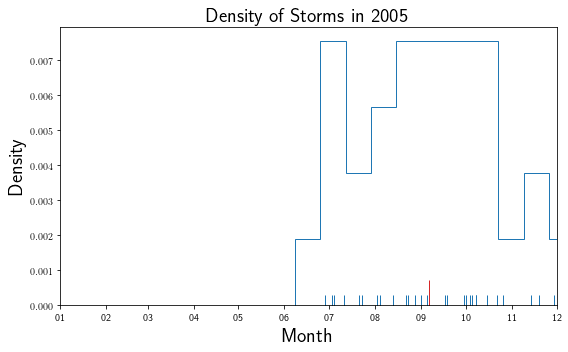

In [30]:
idx_2005 = df['year'] == 2005
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.histogram(Adf['num_dates'].loc[idx_2005], bins=365//30)
bp.rug(Adf['num_dates'].loc[idx_2005].values, markersize=20)
bp.rug(Adf['median'].loc[idx_2005].values[:1], markersize=50, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Density of Storms in 2005', fontsize=20)
ax.set_xlim([datetime.datetime(2005, 1, 1), 
             datetime.datetime(2005, 12, 1)])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m')) 
plt.tight_layout()

By this definition, across all the years, the median storm dates generaly fall in August or September.  The following table depicts the counts of the median storm date within each numbered month, over all the years for which we have data.

In [31]:
Adf.drop_duplicates('year', inplace=False)['median_date'].dt.month.value_counts().sort_index()

7      1
8     23
9     42
10     1
Name: median_date, dtype: int64

The median storm date strictly measures an average storm date within year $Y$. Variation on the other hand measures average distance from the median storm date.  We measure distance from the median storm date in days.  Since some storms form before the median storm date and some storms after, we take the absolute value of the distance of each storm from the median storm date. Our MAD estimator is the median of the absolute values of these distances.  The last step scales our MAD estimator by $\frac{1}{\Phi^{-1}(0.75)} \approx 1.4826$, in a fairly standard assumption of normal data.  In the end, we have MAD estimates of the variation of the empirical storm season for each year in our data set.

To help visualize this calculation, consider the plot above.  For each storm (blue ticks), count the days between each storm and the median storm date (red tick), disregarding any potential negative signs.  From these counts, calculate the median and then scale it by $1.4826$.  This calcuation is done for each year, and we refer to the collection of yearly statistics as the MAD estimates.

In [33]:
Adf['mad'] = Adf.apply(lambda x: np.abs((x['num_dates'] - x['median'])), axis=1)
sdf = (Adf[['year', 'mad']].groupby('year', as_index=False)
            .aggregate(lambda x: 1.4826*np.median(x)))

A plot of the MAD estimates across time appears to show a subtle, positive slope.  A non-zero slope would indicate a change in the variation of the empirical storm season across time.  Hence, to answer Dean Hassenzahl's question, we seek to quantify statistically the slope of the following data.

A standard first attempt would fit simple linear regression to these data.  However, fitting linear regression to these data strictly ignores any possible correlation in storm seasons across time.  In this scenario, each year is treated as independent.  Recall, both Kossin and Kim treated their data as independent across time.  

Treating each year as independent can be suspicious and can lead to over confident conclusions.  We are mainly interested in the semilocal linear trend model mentioned previously.  As a comparison, we fit linear regression and the semilocal linear trend model.

The plot below depicts the MAD estimates of the storm season by year in blue, with the estimate from linear regression overlayed in red.  The subtle negative slope indicates that, if anything, the variation of the emprical storm season is decreasing in time.  The negative sign of this slope agrees qualitatively with Kim, but disagrees with Kossin and Karloski.  Nevertheless, here we are most interested in the uncertainty of this slope estimate.

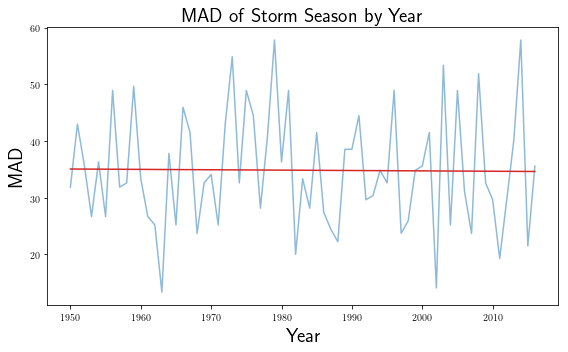

In [34]:
reg = sm.OLS(sdf['mad'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('MAD', fontsize=20)
plt.title('MAD of Storm Season by Year', fontsize=20)
plt.tight_layout()

The plot above looks reasonable and the slope point estimate is reasonable given the uncertainty seen in that point estimate.  We should not focus on the p-value, rather we should focus on the standard error in the estimated coefficient year.

In [35]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mad   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                  0.009973
Date:                Wed, 04 Jul 2018   Prob (F-statistic):              0.921
Time:                        17:13:23   Log-Likelihood:                -251.32
No. Observations:                  67   AIC:                             506.6
Df Residuals:                      65   BIC:                             511.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.9342    131.006      0.366      0.716    -213.703     309.571
year          -0.0066      0.066     -0.100      0.921      -0.139       0.125
==============================================================================
Omnibus:                        1.829   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.784
Skew:                           0.322   Prob(JB):                        0.410
Kurtosis:                       2.527   Cond. No.                     2.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The above regression output provides us a number of important summary statistics.  The slope is estimated to be $-0.007$ with a standard error one order of magnitude larger.  This indicates low confidence in the slope estimate.

The Durbin-Watson statistic is greater than 2, possibly indicating negative autocorrelation in these data, but there's likely to be high uncertainty in that statistic as well.

Nevertheless, we build upon this simple model by at least allowing possible autocorrelation within the model.  We next fit this model, again focusing on the sign of the slope estimate and the associated uncertainty in the slope estimate.

### State Space Model

A more sophisticated model for these data, such that we do not strictly rule out a correlation of the storm seasons across time, is the following Bayesian structural time series model.  This model is comparable to the local linear trend model, sometimes called the semilocal linear trend model

$$
\begin{align}
y_t & = \mu_t + \epsilon_t \\
\mu_{t+1} & = \mu_t + \nu_t + \gamma_t \\
\nu_{t+1} & = \eta + \phi(\nu_t - \eta) + \zeta_t \\ 
\epsilon_t & \sim \mathbb{N}(0, \sigma_y^2) \\
\gamma_t & \sim \mathbb{N}(0, \sigma_{\mu}^2) \\
\zeta_t & \sim \mathbb{N}(0, \sigma_{\nu}^2) \\
\end{align}
$$

where $y_t$ is the time series of interest and $\epsilon_t, \gamma_t$, and $\zeta_t$ are independent.  We use $\mathbb{N}(0, \sigma^2)$ to stand for a normal random variable with mean $0$ and variance $\sigma^2$.

The variable $\eta$ is of most interest as it is a long run slope in the time series; the slope back towards which the deviations $\nu_{t}$ will drift.  For more details on this model, consult [Time Series Analysis by State Space Methods](https://www.amazon.com/Time-Analysis-State-Space-Methods/dp/019964117X/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=BXZQ1XM11ZFFZDP4QVSP) and the [R](https://cran.r-project.org/)  package [bsts](https://cran.r-project.org/web/packages/bsts/index.html)'s help page on their semilocal linear trend model or their blog post about the [semilocal linear trend model](http://www.unofficialgoogledatascience.com/2017/07/fitting-bayesian-structural-time-series.html).

Here, the time series of interest $y_t$ is the yearly MAD estimates of variation of the empirical storm season. Since this model will better handle possible correlations across time in the MAD estimates of variation, we will have an appropriate estimate of the variation in the long run slope.

In Stan, we write this model as follows.  The priors are discussed in the next subsection.

In [55]:
local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/semilocal_linear.stan').text
print(local_linear)

data {
  int <lower=1> T;
  vector[T] x;
  vector[T] y;
}
transformed data {
  real sd_y = sd(y);
  real sd_x = sd(x);
}
parameters {
  real<lower=0> sigma_y;
  vector[T] gamma;
  real<lower=0> sigma_gamma;
  vector[T] zeta;
  real<lower=0> sigma_zeta;
  real eta;
  real<lower=-1, upper=1> phi;
}
transformed parameters {
  vector[T] mu;
  vector[T] nu;

  mu[1] = y[1] + sigma_gamma * gamma[1];
  nu[1] = zeta[1];
  for (t in 2:T) {
    mu[t] = mu[t-1] + nu[t-1] + sigma_gamma * gamma[t];
    nu[t] = eta + phi * (nu[t-1] - eta) + sigma_zeta * zeta[t];
  }
}
model {
  // likelihood
  y ~ normal(mu, sigma_y);

  // priors
  sigma_y ~ exponential(1 / sd_y);
  gamma ~ normal(0, 1);
  sigma_gamma ~ gamma(2, 1 / sd_y);
  zeta ~ normal(0, 1);
  sigma_zeta ~ gamma(2, 1 / sd_y);
  eta ~ student_t(3, 0, sd_y / sd_x);
  phi ~ normal(0, 0.5);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = normal_rng(mu[t], sigma_y);
}



In order to fit this model to the yearly variation in the storm season, we need to compile the above Stan program.

In [37]:
stmod = pystan.StanModel(model_code=local_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5a67a1a28bbc98cedc1cecc2429214e NOW.


#### Model Priors

The semilocal linear trend model above is fit as a Bayesian model, hence there are priors are on all parameters.  An effort has been made such that all priors weakly informative.  We tried to follow a combination of the [guidelines established by the Stan community](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) and the default [priors for rstanarm](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html) [Stan-Development-Team:2016].

Specifically, the parameters $\sigma_y, \sigma_{\gamma}, \sigma_{\zeta}, \eta$, and $\phi$ have priors.  Let $y = (y_1, \
\ldots, y_T)'$ denote the observations of interest and $x$ be the x-axis values along which the observations $y$ are observed.

$$
\begin{align}
\sigma_y & \sim \text{Exponential}(1 / \text{sd}(y) ) \\
\sigma_{\gamma} & \sim \Gamma(2, 1 / \text{sd}(y) ) \\
\sigma_{\zeta} & \sim \Gamma(2, 1 / \text{sd}(y) ) \\
\eta & \sim \mathbb{t}_3(0, \text{sd}(y) / \text{sd}(x) ) \\
\phi & \sim \mathbb{N}(0, 0.5) \\
\end{align}
$$

The prior on $\sigma_y$ attempts to match the scale of the standard deviation of the observations $y$ by scaling an $\text{Exponential(1)}$ distribution appropriately.  The scales parameters of $\gamma$ and $\zeta$ are given boundary avoiding priors scaled the same as $\sigma_y$. The prior on $\eta$ is treated as a regression coefficient in a multiple regression model and thus has a t-distribution on it with degrees of freedom that allow for as wide a distribution as possible with a finite variance.  Since $\eta$ is a slope parameter it is given the ratio of standard deviations of $y$ and $x$ to match the scale of a simple linear regression slope of $y$ on $x$.  The prior on $\phi$ attempts to weakly inform $\phi$ towards 0 with a standard deviation of 0.5.  This leaves room for the data to insist upon a posterior distribution on $\phi$ to be near the extremes $-1$ or $1$.  


### Atlantic Ocean

The above model is fit with Stan, and random samples from the joint posterior distribution over the model parameters are extracted.  We next evaluate the fit of the model and discuss the interpretation of the model in the context of the data.

In [38]:
sdata = {                                                                            
    'T': sdf.shape[0], 
    'x': np.arange(sdf.shape[0]),
    'y': sdf['mad'].values.ravel()
}
stfit = stmod.sampling(data=sdata,
                      control={'adapt_delta': .98})                                                                                                                                    
posterior = stfit.extract()  

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Stan models, like many other sophisticated, statistical models, are susceptible to fitting problems. The interested reader may refer to Section 34 of the [Stan reference manual](http://mc-stan.org/users/documentation/index.html) for further details.  For now, the checks below help assure us that this model applied to these data offer little to be concerned about.

In [39]:
stan_utility.check_treedepth(stfit)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
5.0 of 4000 iterations ended with a divergence (0.125%)
  Try running with larger adapt_delta to remove the divergences
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


The plot below superimposes our fitted model over the MAD estimates of the yearly variation of the empirical storm season.

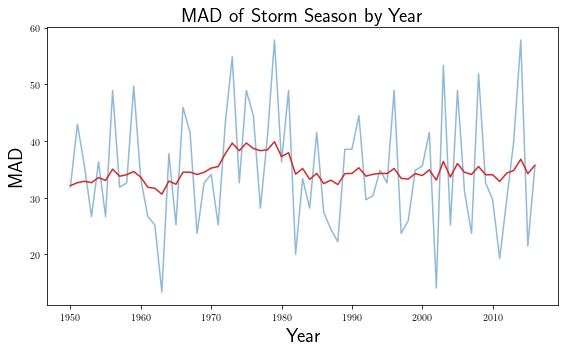

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('MAD', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('MAD of Storm Season by Year', fontsize=20)
plt.tight_layout()

The variable $\eta$ defines the long run slope of the variation of the MAD estimates.  The point estimate of this model is similar to the point estimate from simple linear regression.  Here, however, we have an accurate estimate of the variation of the long run slope.

The median of the posterior distrbution of the long run slope, $\eta$, from the semilocal linear trend model is $.08$.  Below, $80$% and $95$% credible intervals provide estimates of error of $\eta$.  The density below, with $2.5, 10, 50, 90$, and $97.5$ percentiles drawn as short, blue ticks, depicts the posterior distribution of $\eta$.

We find evidence of a slight postive slope in MAD estimates across time.  The semilocal linear trend model shows that there is more noise in the estimate of slope than does simple linear regression.  We are not convinced that the slope estimate is significant.

Linear regression slope estimate: -0.006597090749461623
[-0.55677719 -0.32621416  0.02640406  0.36398323  0.59695901]


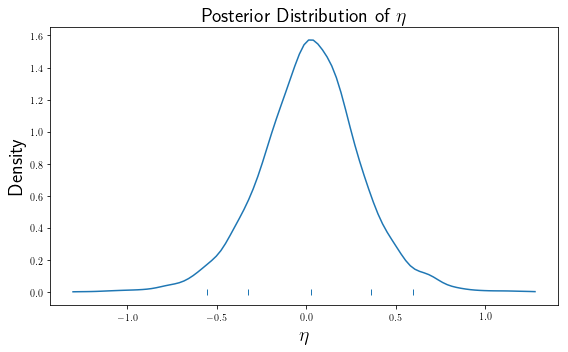

In [41]:
eta_percentiles = np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5])
print("Linear regression slope estimate: {}".format(reg.params[1]))
print(eta_percentiles)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['eta'])
bp.rug(eta_percentiles)
plt.ylabel('Density', fontsize=20)
plt.title('Posterior Distribution of $\eta$', fontsize=20)
plt.xlabel('$\eta$', fontsize=20)
plt.tight_layout()

In short, we have some evidence that the variation of the empirical storm season is not changing in time.  

Nonetheless, there are other ways to address the idea of Dr. Hassenzahl's question.  Next, we investigate whether or not the proportion of storms occuring outside of the official storm season is changing in time.

### Pacific Ocean

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
4.0 of 4000 iterations ended with a divergence (0.1%)
  Try running with larger adapt_delta to remove the divergences
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters
Linear regression slope estimate: -0.004147888339256261
[-0.78465873 -0.49133455 -0.01003326  0.4794347   0.81819444]


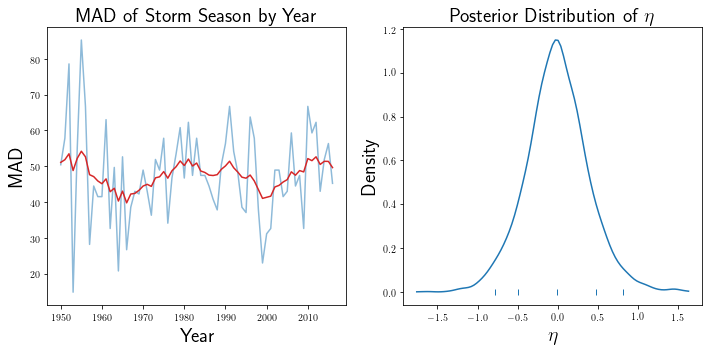

In [56]:
## Prep data for Pacific
Pdf = df.loc[~df['name'].str.contains('^AL')].copy() # Pacific Ocean
Pdf['median'] = Pdf.groupby('year')['num_dates'].transform(lambda x: x.median())
Pdf['median_date'] = mdates.num2date(Pdf['median'])
Pdf['mad'] = Pdf.apply(lambda x: np.abs((x['num_dates'] - x['median'])), axis=1)
sdf = (Pdf[['year', 'mad']].groupby('year', as_index=False)
            .aggregate(lambda x: 1.4826*np.median(x)))

## Fit model in Stan
sdata = {                                                                            
    'T': sdf.shape[0], 
    'x': np.arange(sdf.shape[0]),
    'y': sdf['mad'].values.ravel()
}
stfit = stmod.sampling(data=sdata,
                      control={'adapt_delta': .98})                                                                                                                                    
posterior = stfit.extract()  

## Evaluation fit
stan_utility.check_treedepth(stfit)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

## Plot observations, semilocal linear trend fit, and 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))                                                                      
bp.curve(sdf['year'], sdf['mad'], alpha=0.5, ax=ax[0])                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red', ax=ax[0])     
ax[0].set_ylabel('MAD', fontsize=20)                                                              
ax[0].set_xlabel('Year', fontsize=20)
ax[0].set_title('MAD of Storm Season by Year', fontsize=20)

eta_percentiles = np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5])
print("Linear regression slope estimate: {}".format(reg.params[1]))
print(eta_percentiles)

## the posterior density of eta
bp.density(posterior['eta'], ax=ax[1])
bp.rug(eta_percentiles, ax=ax[1])
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_title('Posterior Distribution of $\eta$', fontsize=20)
ax[1].set_xlabel('$\eta$', fontsize=20)
plt.tight_layout()

## Annual percentage of storms outside official storm season changing?

### Atlantic Ocean

The official storm season is between June 01 and November 30.  In some years, all the storms form within the official storm season.  In other years, there are a few storms that form outside the official storm season.  Next, we consider the yearly percentage of storms that form outside of the official storm season.  This percentage is calculated for each year as follows.  Divide the number of storms that form outside the official storm season in a given year by the number of named storms that formed in that year and then multiple by 100.  If this yearly percentage were to trend up or down over time, we might believe that the empirical storm season were changing.

First, we calculate the percentage of storms forming outside of the official storm season for each year.

In [42]:
def outside_SS(df):
    y = df['year'].values[0]
    early = np.sum(df['date'] < datetime.datetime(y, 6, 1))
    late = np.sum(df['date'] > datetime.datetime(y, 10, 30))
    return 100 * (early + late) / df['year'].shape[0]

sdf['prop'] = Adf.groupby('year', as_index=False).apply(outside_SS)

Plotting these percentages over time shows that there were many years before 1975 where there were 0 storms outside of the storm season.  From about 1975 forward, there appears to always be some storms that formed outside of the official storm season.  In no years were all the storms outside of the official storm season.

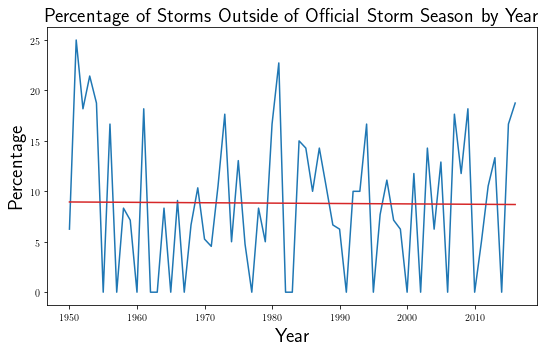

In [43]:
reg = sm.OLS(sdf['prop'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'])
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Percentage of Storms Outside of Official Storm Season by Year', fontsize=20)
plt.tight_layout()

We analyze these percentages using the same semilocal linear trend model as above.    If the slope parameter $\eta$ is significantly non-zero, we'll have found some evidence in a changing proportion of storms occuring outside of the official storm season.

In [44]:
sdata = {                                                                            
    'T': sdf.shape[0], 
    'x': np.arange(sdf.shape[0]),
    'y': sdf['prop']
}
stfit = stmod.sampling(data=sdata,
                      control={'adapt_delta': .98}) 
posterior = stfit.extract() 

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [45]:
stan_utility.check_treedepth(stfit)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
5.0 of 4000 iterations ended with a divergence (0.125%)
  Try running with larger adapt_delta to remove the divergences
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


The plot below displays the semilocal linear trend estimates of the percentages of storms that formed outside of the official storm season.  The model estimates are drawn in red and are superimposed over the light blue observations.  It appears to have a gentle positive slope.

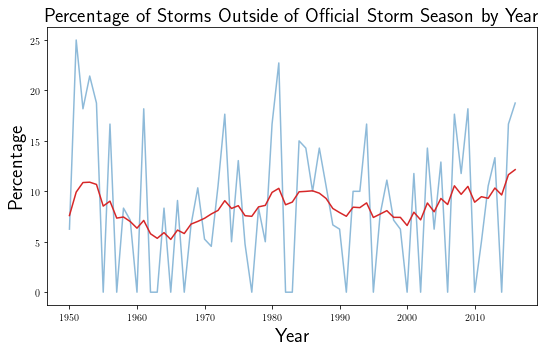

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['prop'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Percentage', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Percentage of Storms Outside of Official Storm Season by Year', fontsize=20)
plt.tight_layout()

The posterior distribution of $\eta$ appears below, alongside multiple percentiles.  While the median of $\eta$ is positive, even the $80$\% credible interval includes 0.  While I certainly don't want to make a binary conclusion here, it appears that there is much noise in the estimate of the long term slope parameter $\eta$.

Linear regression slope estimate: -0.0038128475204844752
[-0.42914957 -0.22325792  0.02947849  0.29154623  0.46341397]


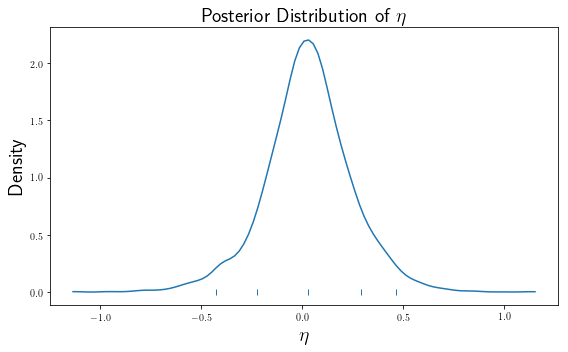

In [47]:
eta_percentiles = np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5])
print("Linear regression slope estimate: {}".format(reg.params[1]))
print(eta_percentiles)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['eta'])
bp.rug(eta_percentiles)
plt.ylabel('Density', fontsize=20)
plt.xlabel('$\eta$', fontsize=20)
plt.title('Posterior Distribution of $\eta$', fontsize=20)
plt.tight_layout()

It doesn't appear that the percentage of storms occuring outside of the official storm season is changing over time.

Last, we analyze the stationarity of the empirical storm season.

### Pacific Ocean

## Is the Distribution of the Empirical Storm Season Stationary?

### Atlantic Ocean

Consider the average density [histogram](#average_density) above, where the empirical storm season was averaged over all the years for which we have data.  Let's refer to this histogram as the average storm season.  If the empirical storm season was not changing over time, then this average storm season would represent the stationary distribution from which each year's storm season was randomly drawn.  If such a stationary storm season producing distribution exists, then no year's storm season in our data set should be too different from the average storm season.

To evaluate the stationarity of the storm season, we compute such a histogram for each year's empirical storm season separately.  For instance, consider the [histogram of the storms from 2005](#2005_density).  Now imagine we overlayed the average storm season histogram with the histogram from the 2005 storm season.  We calculate the maximal, absolute difference between these two histograms.  This idea is most easily visualized with histograms, but in fact we do all the calculations with the empirical cumulative distribution functions of the empirical storm seasons.  Intuitively, these ideas are similar.  In fact, this is just the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (KS) statistic, for each year's storm season relative to the average storm season.

We walk through each step of the calculations involved.  First, we calculate the average storm season.

In [48]:
hist, bins = np.histogram(Adf['cnum_dates'], 
                          bins=Adf['cnum_dates'].nunique(), density=True)
cdf = np.cumsum(hist)
ecdf = cdf/cdf[-1]

Next, we'll replicate this calculation for each year in our data set.

In [49]:
ks = []
for year in np.nditer(Adf['date'].dt.year.unique()):
    h, _ = np.histogram(Adf['cnum_dates'][df['date'].dt.year == year], 
                        bins=Adf['cnum_dates'].nunique(), density=True)
    bcdf = np.cumsum(h)
    ks.append(np.max(np.abs(ecdf - bcdf/bcdf[-1])))
sdf['KS'] = np.array(ks)*100

When we put the inappropriate linear regression line through these data, it appears to have a negative slope.  We remind the reader that the yearly KS statistics appear in absolute value.  Hence, a (possible) negative slope is not as indicative as the word negative connotes.  Here, any slope, positive or negative, will simply suggest a non-stationary storm season.

I stand by the inappropriateness of any linear regression solution.  I only present it here as a reminder, that which the eye wants to see is not necessarily statistically so, even if one produces a small p-value in an attempt to back up their claim.

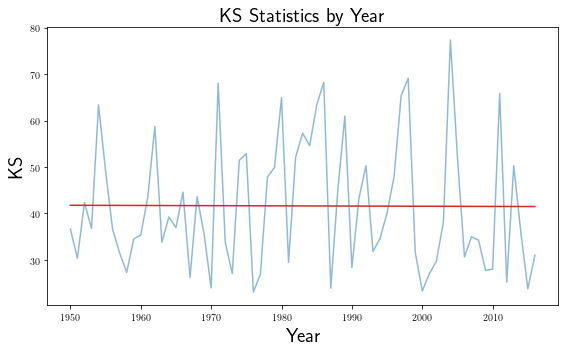

In [50]:
reg = sm.OLS(sdf['KS'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['KS'], alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('KS', fontsize=20)
plt.title('KS Statistics by Year', fontsize=20)
plt.tight_layout()

In [51]:
sdata = {                                                                            
    'T': sdf.shape[0], 
    'x': np.arange(sdf.shape[0]),
    'y': sdf['KS']
}
stfit = stmod.sampling(data=sdata, 
                       control={'adapt_delta': .975,
                                'max_treedepth': 15}) 
posterior = stfit.extract()

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [52]:
stan_utility.check_treedepth(stfit, max_depth=15)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 15 (0.0%)
E-BFMI indicated no pathological behavior
8.0 of 4000 iterations ended with a divergence (0.2%)
  Try running with larger adapt_delta to remove the divergences
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


The semilocal linear trend model smoothes out the yearly KS statistics.  Similar to linear regression, there appears to be a negative slope.

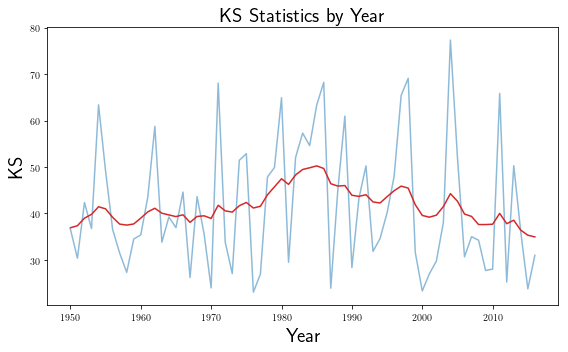

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['KS'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')  
plt.ylabel('KS', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('KS Statistics by Year', fontsize=20)
plt.tight_layout()

The posterior distribution of $\eta$ is noisy, despite the negative median value.

Linear regression slope estimate: -0.004147888339256261
[-0.87817275 -0.51120452 -0.0088408   0.49094214  0.81301906]


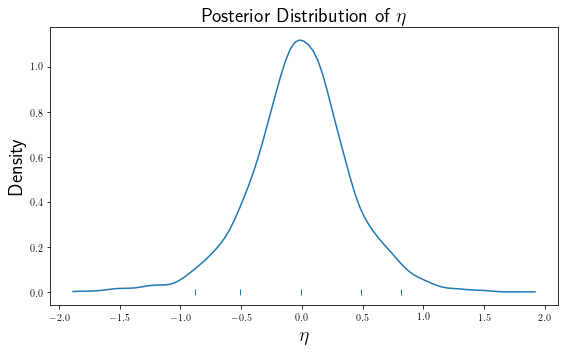

In [54]:
eta_percentiles = np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5])
print("Linear regression slope estimate: {}".format(reg.params[1]))
print(eta_percentiles)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['eta'])
bp.rug(eta_percentiles)
plt.ylabel('Density', fontsize=20)
plt.title('Posterior Distribution of $\eta$', fontsize=20)
plt.xlabel('$\eta$', fontsize=20)
plt.tight_layout()

We find little evidence that the empirical storm season is non-stationary, since the posterior distribution of $\eta$ is so noisy about $0$.

### Pacific Ocean

# Conclusion

This blog post analyzed the variation of the empirical storm season in two different ways.  First, we considered the MAD estimates of the variation of the empirical storm season.  Second, we analyzed the percentage of storms that occured outside of the official storm season.  Neither of these analyses found evidence of significant changes in the variation of the empirical storm season.  

The last analysis considered the stationarity of the empirical storm season by investigating the slope of the yearly maximal discrepancy between the average storm season and each year's storm season.  Here, we calculated one KS statistic for each year in our data set.  Unlike the first two analyses, the KS statistic will identify any changes in distribution, not just the average or variance.  Yet, even with the yearly KS statistics, we still didn't find any significant changes in the empirical storm season.

A strong word of caution is in order.  None of the work here said anything about the [intensity of storms](https://www.ncdc.noaa.gov/news/tropical-cyclone-%E2%80%9Cmaximum-intensity%E2%80%9D-shifting-toward-poles), nor the length of storms [XXX cite me], nor the [speed of storms](https://www.ncei.noaa.gov/news/tropical-cyclone-slowdown), nor changes in anything that may influence storms [Karloski:2016].  In part, our focus on the variation of the empirical storm makes this analysis unique.  However, as we largely didn't discover any broad changes in the empirical storm season, we didn't find much of interest.  Which is to say, there may be a reason so many other people have focused their attention elsewhere; that's where all the interesting things are happening.

# Acknowledgments

This blog post would not have happened without the great minds of Dave Hassenzahl, Ann Bykerk-Kauffman, and the Department of Geological and Environmental Sciences.  Rachel Hensler provided excellent feedback.  And of course, the communities of Python, Stan, and NOAA's National Hurricane Center deserve much credit for their endless hard work.

# References

[Carpenter:2017] B. Carpenter, A. Gelman, M. D. Hoffman, D. Lee, B. Goodrich, M. Betancourt, M. Brubaker, J. Guo, P. Li, and A. Riddell. Stan: A probabilistic programming language. Journal of statistical software, 76(1), 2017. https://www.jstatsoft.org/article/view/v076i01

[Durbin:2012] J. Durbin and S. J. Koopman. Time Series Analysis by State Space Methods. Oxford University Press, 2 edition, 2012.

[Karloski:2016] J. M. Karloski and C. Evans. Seasonal influences upon and long-term trends in the length of the atlantic hurricane season. Journal of Climate, 29(1):273–292, 2016.  https://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-15-0324.1

[Kim:2017] D. Kim, H.-S. Kim, D.-S. R. Park, and M.-S. Park. Variation of the tropical cyclone season start in the western north pacific. Journal of Climate, 30(9):3297–3302, 2017. https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0888.1

[Kossin:2008] J. P. Kossin. Is the north atlantic hurricane season getting longer? Geophysical Research Letters, 35(23), 2008. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2008GL036012

[Landsea:2013] C. W. Landsea and J. L. Franklin. Atlantic hurricane database uncertainty and presentation of a new database format. Monthly Weather Review, 141(10):3576–3592, 2013. https://journals.ametsoc.org/doi/10.1175/MWR-D-12-00254.1

[R-Core-Team:2018] R Core Team. R: A Language and Environment for Statistical Computing. R Foundation for Statistical Computing, Vienna, Austria, 2018. https://www.R-project.org

[Stan-Development-Team:2016] Stan Development Team. rstanarm: Bayesian applied regression modeling via Stan., 2016. R package version 2.13.1. http://mc-stan.org/rstanarm/index.html

[Scott:2018] S. L. Scott. bsts: Bayesian Structural Time Series, r package version 0.8.0 edition, 2018. https://CRAN.R-project.org/package=bsts

# Licenses

Code: Copyright (2018) California State University, Chico. Released under the BSD 3-clause license. https://opensource.org/licenses/BSD-3-Clause

Text: Copyright (2018) Edward A. Roualdes. Released under the the CC BY-NC 4.0 license. https://creativecommons.org/licenses/by-nc/4.0/legalcode